<a href="https://www.kaggle.com/code/mizette/notebookdde429ad79?scriptVersionId=102289803" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [2]:
train_data = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
test_data = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv')

In [3]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
test_data.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [5]:
print(train_data.shape, test_data.shape)

(159571, 8) (153164, 2)


**PREPROCCESING**


**1. LOWERCASING THE TEXT**

In [6]:
train_data.comment_text = [text.lower() for text in train_data.comment_text]
test_data.comment_text = [text.lower() for text in test_data.comment_text]

**2. TOKENIZATION**

In [7]:
from nltk.tokenize import word_tokenize
train_data.comment_text = [word_tokenize(text) for text in train_data.comment_text]
test_data.comment_text = [word_tokenize(text) for text in test_data.comment_text]

**3. REMOVING STOP WORDS**

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
train_data.comment_text = [word for word in train_data.comment_text if not word in stop]
test_data.comment_text = [word for word in test_data.comment_text if not word in stop]

**4. STEMMING AND LEMMATIZATION**

In [9]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stem = PorterStemmer()
lem = WordNetLemmatizer()

def stem_lem(data):
    lemmatized = []
    for text in data:
        final = []
        for word in text:
            #Check if the recursion depth does not exceed
            if len(word) < 990:
                stem.stem(word)
                final.append(lem.lemmatize(word))
        lemmatized.append(final)
    return lemmatized

train_data.comment_text = stem_lem(train_data.comment_text)
test_data.comment_text = stem_lem(test_data.comment_text)

**BULDING RNN WITH TENSORFLOW**

In [10]:
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, Bidirectional, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import Sequential
from keras.preprocessing import text
#from keras.utils import pad_sequences
from keras_preprocessing.sequence import pad_sequences

In [11]:
X_train = train_data["comment_text"]
y_train = train_data[["toxic", 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
X_test = test_data["comment_text"]

tokenizer = text.Tokenizer()

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_l = 100

X_train = pad_sequences(X_train, maxlen = max_l)
X_test = pad_sequences(X_test, maxlen = max_l)

In [12]:
model = Sequential()
model.add(Embedding(20000, 50, input_shape = (100, )))
model.add(Bidirectional(LSTM(50, dropout=0.1)))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

2022-08-01 21:15:35.379383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 21:15:35.515142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 21:15:35.515912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 21:15:35.517667: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
history = model.fit(X_train, y_train, epochs = 2, validation_split = 0.1, batch_size = 32, callbacks=[tensorboard])

2022-08-01 21:15:39.259692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-08-01 21:15:43.260816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/4488 [..............................] - ETA: 6:38:40 - loss: 0.6922 - accuracy: 0.2812

2022-08-01 21:15:44.765201: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-01 21:15:44.765257: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/4488 [..............................] - ETA: 32:22 - loss: 0.6896 - accuracy: 0.2188  

2022-08-01 21:15:45.083251: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-01 21:15:45.084578: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-01 21:15:45.226746: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1218 callback api events and 1215 activity events. 
2022-08-01 21:15:45.250914: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  11/4488 [..............................] - ETA: 6:15 - loss: 0.6517 - accuracy: 0.0824

2022-08-01 21:15:45.297091: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_08_01_21_15_45

2022-08-01 21:15:45.317522: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_08_01_21_15_45/98dda8b70152.trace.json.gz
2022-08-01 21:15:45.361538: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_08_01_21_15_45

2022-08-01 21:15:45.366195: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2022_08_01_21_15_45/98dda8b70152.memory_profile.json.gz
2022-08-01 21:15:45.367191: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2022_08_01_21_15_45
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2022_08_01_21_15_45/98dda8b7

4488/4488 [==============================] - 64s 13ms/step - loss: 0.0688 - accuracy: 0.9449 - val_loss: 0.0529 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 57s 13ms/step - loss: 0.0490 - accuracy: 0.9866 - val_loss: 0.0515 - val_accuracy: 0.9940


Text(0, 0.5, 'accuracy')

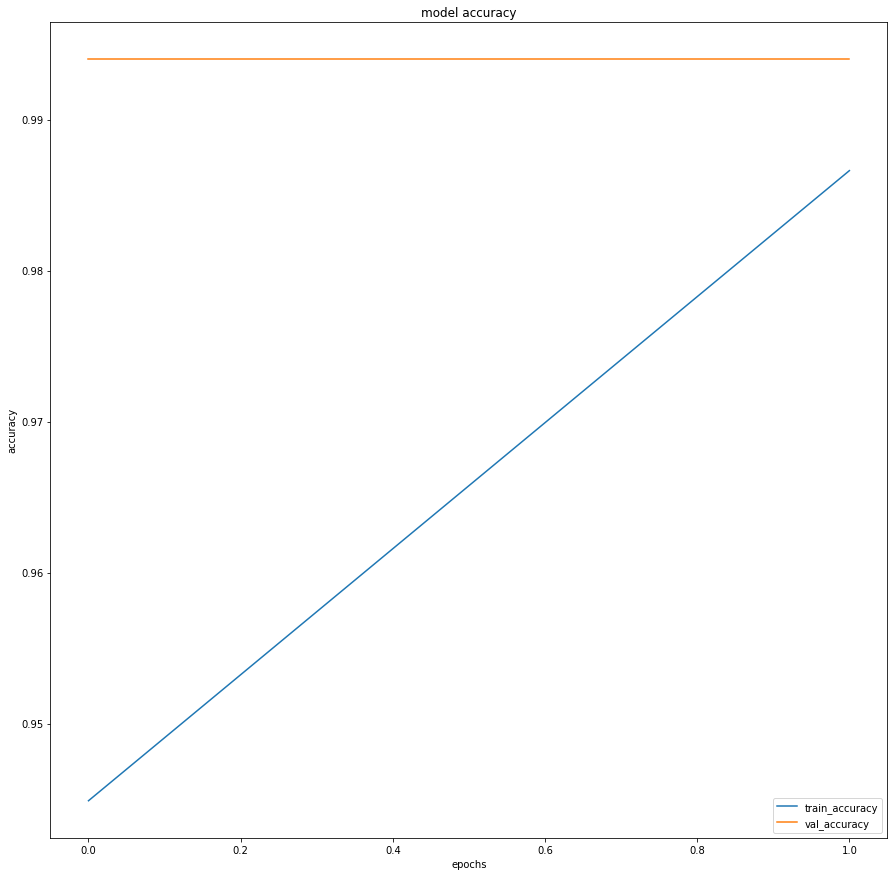

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 15))
plt.title('model accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

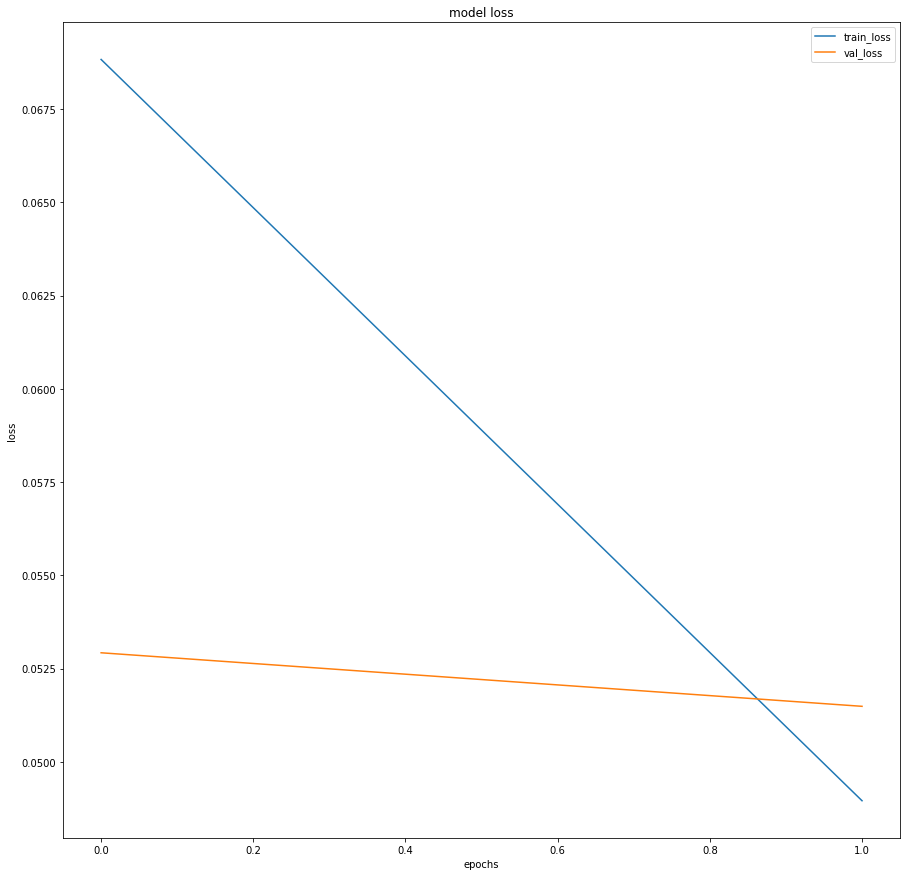

In [15]:
plt.figure(figsize= (15, 15))
plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [16]:
predictions = model.predict(X_test)

In [17]:
df = pd.DataFrame({'id': test_data['id']})
cols = train_data[["toxic", 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
predictions_df = pd.concat([df, pd.DataFrame(predictions, columns = cols.columns)], axis=1)
predictions_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.990491,0.221097,0.901238,0.055917,0.804967,0.157639
1,0000247867823ef7,0.001753,0.000007,0.000197,0.000025,0.000167,0.000036
2,00013b17ad220c46,0.035620,0.000072,0.003022,0.000641,0.005233,0.001156
3,00017563c3f7919a,0.003214,0.000008,0.000352,0.000027,0.000322,0.000051
4,00017695ad8997eb,0.003544,0.000016,0.000417,0.000062,0.000409,0.000089
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.009338,0.000042,0.001148,0.000210,0.001340,0.000301
153160,fffd7a9a6eb32c16,0.002114,0.000008,0.000219,0.000026,0.000197,0.000038
153161,fffda9e8d6fafa9e,0.003026,0.000008,0.000401,0.000020,0.000336,0.000046
153162,fffe8f1340a79fc2,0.002284,0.000013,0.000530,0.000015,0.000300,0.000041
